In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
import numpy as np
import pandas as pd
import datetime as dt
import config as cfg

from sqlalchemy import create_engine
import psycopg2

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Import Data from Postgre

In [32]:
# import data from AWS RDS Database


conn_string = "host="+cfg.PGHOST +" port="+ "5432" +" dbname="+ cfg.PGDATABASE +" user=" + cfg.PGUSER \
                  +" password="+ cfg.PGPASSWORD
    
conn = psycopg2.connect(conn_string)
cur = conn.cursor()

df = pd.read_sql_query('select * from weather_aus_raw', conn)
df.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,2008-12-01,Albury,13.4,22.9,0.6,9999.0,9999.0,W,44.0,W,...,1007.1,8.0,9999.0,16.9,21.8,No,No,2008,12,1
1,2008-12-02,Albury,7.4,25.1,0.0,9999.0,9999.0,WNW,44.0,NNW,...,1007.8,9999.0,9999.0,17.2,24.3,No,No,2008,12,2
2,2008-12-03,Albury,12.9,25.7,0.0,9999.0,9999.0,WSW,46.0,W,...,1008.7,9999.0,2.0,21.0,23.2,No,No,2008,12,3
3,2008-12-04,Albury,9.2,28.0,0.0,9999.0,9999.0,NE,24.0,SE,...,1012.8,9999.0,9999.0,18.1,26.5,No,No,2008,12,4
4,2008-12-05,Albury,17.5,32.3,1.0,9999.0,9999.0,W,41.0,ENE,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5


## Review the Data

In [33]:
df.shape

(145460, 26)

In [34]:
# Check Datatypes

df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday         object
raintomorrow      object
year               int64
month              int64
day                int64
dtype: object

In [35]:
df.isna().count()

date             145460
location         145460
mintemp          145460
maxtemp          145460
rainfall         145460
evaporation      145460
sunshine         145460
windgustdir      145460
windgustspeed    145460
winddir9am       145460
winddir3pm       145460
windspeed9am     145460
windspeed3pm     145460
humidity9am      145460
humidity3pm      145460
pressure9am      145460
pressure3pm      145460
cloud9am         145460
cloud3pm         145460
temp9am          145460
temp3pm          145460
raintoday        145460
raintomorrow     145460
year             145460
month            145460
day              145460
dtype: int64

In [36]:
df['location'].nunique()

49

## Check if Bucketing Required

In [37]:
# Check the unique value counts to see if binning is required
df.year.value_counts()

2016    17934
2014    17885
2015    17885
2009    16789
2010    16782
2013    16415
2012    15409
2011    15407
2017     8623
2008     2270
2007       61
Name: year, dtype: int64

In [38]:
# Check the unique value counts to see if binning is required
df.location.value_counts()

Canberra            3436
Sydney              3344
Hobart              3193
Perth               3193
Melbourne           3193
Brisbane            3193
Darwin              3193
Adelaide            3193
GoldCoast           3040
Bendigo             3040
Launceston          3040
MountGambier        3040
Ballarat            3040
AliceSprings        3040
Albany              3040
Albury              3040
Wollongong          3040
MountGinini         3040
Cairns              3040
Townsville          3040
Penrith             3039
Tuggeranong         3039
Newcastle           3039
Dartmoor            3009
NorfolkIsland       3009
Richmond            3009
Watsonia            3009
Cobar               3009
SydneyAirport       3009
Woomera             3009
PerthAirport        3009
CoffsHarbour        3009
Moree               3009
Witchcliffe         3009
PearceRAAF          3009
Nuriootpa           3009
Mildura             3009
WaggaWagga          3009
MelbourneAirport    3009
BadgerysCreek       3009


## Update "RainTomorrow" and "RainToday" Columns to Binary Values

In [39]:
df['raintomorrow'].value_counts()

No      110316
Yes      31877
9999      3267
Name: raintomorrow, dtype: int64

In [40]:
df['raintoday'].value_counts()

No      110319
Yes      31880
9999      3261
Name: raintoday, dtype: int64

In [41]:
df['raintomorrow'] = df.raintomorrow.eq('Yes').mul(1)
df['raintomorrow'].value_counts()

0    113583
1     31877
Name: raintomorrow, dtype: int64

In [42]:
df['raintoday'] = df.raintoday.eq('Yes').mul(1)
df['raintoday'].value_counts()

0    113580
1     31880
Name: raintoday, dtype: int64

## Drop Columns Not Needed for Machine Learning Model

In [43]:
columns = ['date']
df = df.drop(columns, axis=1)

In [44]:
print(df.shape)
df.head()

(145460, 25)


,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,Albury,13.4,22.9,0.6,9999.0,9999.0,W,44.0,W,WNW,...,1007.1,8.0,9999.0,16.9,21.8,0,0,2008,12,1
1,Albury,7.4,25.1,0.0,9999.0,9999.0,WNW,44.0,NNW,WSW,...,1007.8,9999.0,9999.0,17.2,24.3,0,0,2008,12,2
2,Albury,12.9,25.7,0.0,9999.0,9999.0,WSW,46.0,W,WSW,...,1008.7,9999.0,2.0,21.0,23.2,0,0,2008,12,3
3,Albury,9.2,28.0,0.0,9999.0,9999.0,NE,24.0,SE,E,...,1012.8,9999.0,9999.0,18.1,26.5,0,0,2008,12,4
4,Albury,17.5,32.3,1.0,9999.0,9999.0,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,0,0,2008,12,5


## Encode Columns - Use OneHotEncoder

In [45]:
# Generate our categorical variable list
df_cat = df.dtypes[df.dtypes == "object"].index.tolist()
df_cat

['location', 'windgustdir', 'winddir9am', 'winddir3pm']

In [46]:
df[df_cat].nunique()

location       49
windgustdir    17
winddir9am     17
winddir3pm     17
dtype: int64

In [47]:
# Create the OneHotEncoder instance
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(df[df_cat]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(df_cat)
encode_df.head()


,location_Adelaide,location_Albany,location_Albury,location_AliceSprings,location_BadgerysCreek,location_Ballarat,location_Bendigo,location_Brisbane,location_Cairns,location_Canberra,...,winddir3pm_NNW,winddir3pm_NW,winddir3pm_S,winddir3pm_SE,winddir3pm_SSE,winddir3pm_SSW,winddir3pm_SW,winddir3pm_W,winddir3pm_WNW,winddir3pm_WSW
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(df_cat, axis=1)
df.head()

,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustspeed,windspeed9am,windspeed3pm,humidity9am,humidity3pm,...,winddir3pm_NNW,winddir3pm_NW,winddir3pm_S,winddir3pm_SE,winddir3pm_SSE,winddir3pm_SSW,winddir3pm_SW,winddir3pm_W,winddir3pm_WNW,winddir3pm_WSW
0,13.4,22.9,0.6,9999.0,9999.0,44.0,20.0,24.0,71.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,7.4,25.1,0.0,9999.0,9999.0,44.0,4.0,22.0,44.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,12.9,25.7,0.0,9999.0,9999.0,46.0,19.0,26.0,38.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,9.2,28.0,0.0,9999.0,9999.0,24.0,11.0,9.0,45.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17.5,32.3,1.0,9999.0,9999.0,41.0,7.0,20.0,82.0,33.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
df.columns

Index(['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine',
       'windgustspeed', 'windspeed9am', 'windspeed3pm', 'humidity9am',
       'humidity3pm',
       ...
       'winddir3pm_NNW', 'winddir3pm_NW', 'winddir3pm_S', 'winddir3pm_SE',
       'winddir3pm_SSE', 'winddir3pm_SSW', 'winddir3pm_SW', 'winddir3pm_W',
       'winddir3pm_WNW', 'winddir3pm_WSW'],
      dtype='object', length=121)

## Variable Declaration and Split into Test/Train

In [50]:
# define Target Variable
X = df.copy()
X = X.drop("raintomorrow", axis=1)
y = df["raintomorrow"]

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Scale the Data
#### We will use standard scaler for the model

In [51]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Handle Class Imbalance

- Plot the data to check for class imbalance
- If imbalance exists, evaluate sampling strategies to find the best fit for rainfall data

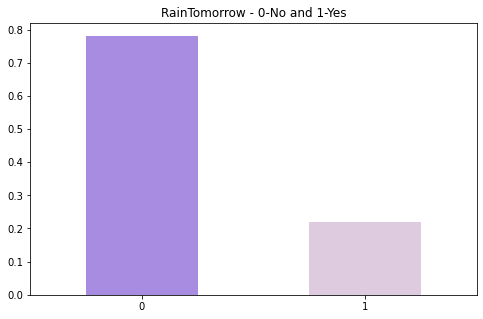

In [52]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
df.raintomorrow.value_counts(normalize = True).plot(kind='bar', color= ['mediumpurple','thistle'], alpha = 0.8, rot=0)
plt.title('RainTomorrow - 0-No and 1-Yes')
plt.show()

<AxesSubplot:>

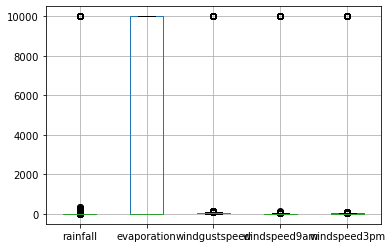

In [53]:

df.boxplot(column=['rainfall','evaporation','windgustspeed','windspeed9am','windspeed3pm'])

In [54]:
# Resample the training data with the RandomOversampler
from collections import Counter

#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=1)
#X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)


#from imblearn.over_sampling import SMOTE
#X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train_scaled, y_train)

from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

Counter(y_resampled)

Counter({0: 42003, 1: 64011})

## Define Machine Learning Model
### We want to evaluate the following three models to find the best fit:
- Random forest
- GBM (Boosting)
- Logistic
####  Balanced Random Forest mockup below

In [55]:
# Create a random forest classifier.

#from sklearn.ensemble import RandomForestClassifier
#rf_model = RandomForestClassifier(n_estimators=128, random_state=42) 

from imblearn.ensemble import BalancedRandomForestClassifier
rf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=42) 

# Fitting the model
rf_model = rf_model.fit(X_resampled, y_resampled)

# Making predictions using the testing data.
y_pred = rf_model.predict(X_test_scaled)



## Model Validation
- Accuracy Report
- Confusion Matrix
- Classification Report



In [61]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,24357,4039
Actual 1,2387,5582


In [62]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.86      0.70      0.88      0.78      0.61     28396
          1       0.58      0.70      0.86      0.63      0.78      0.59      7969

avg / total       0.84      0.82      0.73      0.83      0.78      0.61     36365



In [63]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
balanced_accuracy_score(y_test, y_pred)

0.779112977865295

In [64]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
for importance, feat in sorted(zip(rf_model.feature_importances_, X.columns), reverse=True):
    print(f'{feat}: ({importance})')

humidity3pm: (0.1372955796836361)
rainfall: (0.10842187055463873)
raintoday: (0.07841047538986845)
cloud3pm: (0.04915747597279314)
humidity9am: (0.04250263003357599)
cloud9am: (0.04199528127208247)
sunshine: (0.041944656765873875)
windgustspeed: (0.04034367422102895)
pressure3pm: (0.03478524983391601)
pressure9am: (0.033190835514756684)
maxtemp: (0.031048195807987337)
temp3pm: (0.029831162728477842)
mintemp: (0.025130503910060636)
month: (0.024086958456041845)
temp9am: (0.021662209108579814)
windspeed3pm: (0.02058538262077164)
year: (0.020052974937818133)
windspeed9am: (0.019525076539468566)
day: (0.018384086168969464)
evaporation: (0.015738152369323542)
winddir9am_N: (0.010940371815590814)
windgustdir_N: (0.004805907014029684)
winddir3pm_N: (0.004777798167210489)
winddir3pm_NW: (0.0042873626090518145)
winddir9am_NNE: (0.0036227068948474998)
winddir9am_SE: (0.002997254439211008)
winddir9am_9999: (0.0029729403166252025)
winddir3pm_NNW: (0.002885061590875002)
windgustdir_NW: (0.002733587

In [37]:
from sklearn.linear_model import LinearRegression

X = df.copy()
X = X.drop("Rainfall", axis=1)
y = df["Rainfall"]


# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [38]:
y_pred = lr.predict(X_test)

In [41]:
y_pred

array([ 1.28477002e+01,  2.08776589e+00,  8.53390448e-02,  1.01631401e+01,
        5.83915490e-01,  1.47747473e+00,  1.78100743e+00,  1.19948756e+01,
        1.54649954e+00,  7.35285036e-01, -2.95917888e+00,  1.13973667e+01,
       -1.69249478e+00, -1.56143551e+00, -1.36950622e+00,  1.42416046e+00,
       -1.98634065e+00, -2.00238864e-01,  1.05739256e+01,  1.08176257e+01,
       -1.56956116e+00,  1.21457650e+01,  1.80776775e+00, -2.97457024e-01,
       -2.09977745e+00,  9.55550254e+00, -3.54769813e-01, -1.42591697e+00,
        1.25768008e+01, -1.28638989e+00, -1.14986714e+00, -1.97096483e+00,
        1.38182587e+00,  7.22648899e-01, -7.67172470e-01,  1.07206002e+01,
        1.79204608e-02, -1.44116841e-01,  4.24798262e-01,  1.16666398e+01,
       -1.05485311e+00,  1.10251812e+00,  2.66717463e+00,  2.66342782e+00,
        1.14965926e+01,  2.53732065e+00,  8.10298068e+00,  7.29520290e-01,
       -1.85433941e-01,  1.80752279e-01,  7.38969066e-01,  9.81965040e-01,
        3.88500219e+00, -

In [40]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

NameError: name 'classification_report' is not defined